# DJ GAN

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft

## sounds, FFT and IFFT

In [2]:
# create example sounds
sr = 22050 # sample rate
T = 2.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) 
f1 = 420
f2 = 1000
f3 = 25
x1 = 0.5*np.sin(2*np.pi*f1*t) 
x2 = 0.2*np.sin(2*np.pi*f2*t) 
x = (x1 + x2)*np.sin(2*np.pi*f3*t)

In [3]:
IPython.display.Audio(x,rate=sr, autoplay=True)

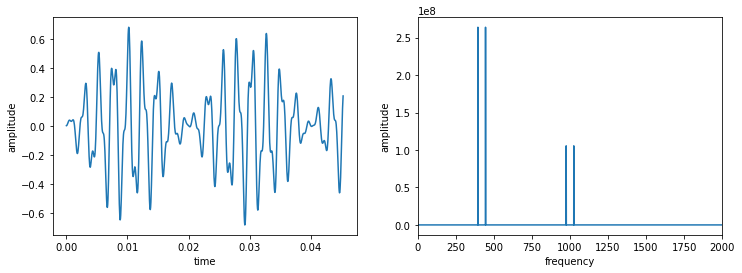

In [4]:
normalized_tone = np.int16((x / x.max()) * 32767)

# go from time domain to frequency domain

# Number of samples in normalized_tone
N = int(sr * T)

yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / sr)

# plot signal and frequencies
fig, axs = plt.subplots(1,2, figsize=(12,4))
ax = axs[0]
n=1000
ax.plot(t[0:n],x[0:n])
ax.set(xlabel='time', ylabel='amplitude')

ax=axs[1]
ax.plot(xf, np.abs(yf))
ax.set(xlabel='frequency', ylabel='amplitude', xlim=(0,2000));

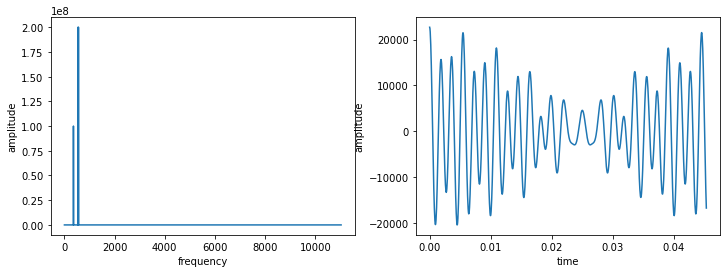

In [5]:
# go from frequency space to time domain
new_sound = np.zeros_like(yf)

f1 = 360
f2 = 540
f3 = 560
i1 = np.argmin(np.abs(xf - f1))
i2 = np.argmin(np.abs(xf - f2))
i3 = np.argmin(np.abs(xf - f3))

new_sound[i1] = 1e8
new_sound[i2] = 2e8
new_sound[i3] = 2e8

# plot frequencies and signal
fig, axs = plt.subplots(1,2, figsize=(12,4))
ax=axs[0]
ax.plot(xf, np.abs(new_sound))
ax.set(xlabel='frequency', ylabel='amplitude',)# xlim=(0,2000))

new_sig = irfft(new_sound)

ax = axs[1]
ax.plot(t[0:n],new_sig[0:n])
ax.set(xlabel='time', ylabel='amplitude');

In [6]:
IPython.display.Audio(new_sig/10000,rate=sr, autoplay=True)

## Generate dataset
We'll start by generating our own very simple dataset with sinusoidal waves with frequencies between 300 and 500 and amplitudes between 0.5 and 1.

In [7]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [8]:
sr = 50000 # sr samples per T seconds
T = 1 # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time
N = int(sr * T)
freqs = rfftfreq(N, 1 / sr) # with sr=5000 and T=1 freqs are from 0 to 2500 with 1 Hz inbetween
amp = 1 # scale of amplitude
norm_t = 1
norm_f = 2500
f_min = 300
f_max = 500

In [9]:
# generate sinusoidal wave with frequency between 300 and 500 and amp between 0.5 and 1
def get_sinusoidal_wave(f_min=300, f_max=500):
    f = np.random.randint(f_min, f_max)
    A = np.random.random()*0.5 + 0.5
    x = A*np.sin(2*np.pi*f*t)
    return x

def to_frequency_domain(x):
    normalized_tone = x/norm_t
    yf = np.abs(rfft(x))/norm_f
    yf = yf * (yf>0.01)
    return yf

def get_data_samples(N=1000, f_min=300, f_max=500):
    data = []
    for i in range(N):
        x = get_sinusoidal_wave(f_min, f_max)
        yf = to_frequency_domain(x)
        data.append(yf)
    
    return np.array(data)

In [10]:
x = get_sinusoidal_wave()
yf = to_frequency_domain(x)

In [11]:
IPython.display.Audio(x,rate=sr, autoplay=True)

[Text(0.5, 0, 'frequency'), Text(0, 0.5, 'amplitude'), None]

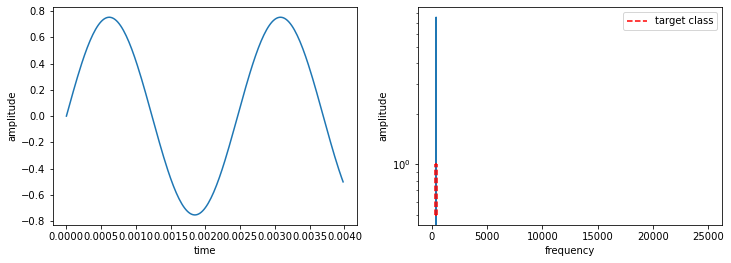

In [12]:
# plot signal and frequencies
fig, axs = plt.subplots(1,2, figsize=(12,4))
ax = axs[0]
n = 200
ax.plot(t[0:n],x[0:n])
ax.set(xlabel='time', ylabel='amplitude')

ax=axs[1]
ax.plot(freqs, yf)
ax.plot([f_min, f_max], [0.5*amp, 0.5*amp], '--r', label='target class')
ax.plot([f_min, f_max], [amp, amp], '--r')
ax.plot([f_min, f_min], [0.5*amp, amp], '--r')
ax.plot([f_max, f_max], [0.5*amp, amp], '--r')
ax.legend()
ax.set(xlabel='frequency', ylabel='amplitude', yscale='log')

In [13]:
# generate data set (numpy)
N_data = 10000
data = get_data_samples(N_data, f_min, f_max)
data.shape

(10000, 25001)

In [14]:
# create dataloader 
batch_size = 64

tensor_x = torch.Tensor(data) # transform to torch tensor

dataset = TensorDataset(tensor_x) # create your datset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # create your dataloader

## The networks
- Discriminator
- Generator

In [15]:
# discriminator network
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 64),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(64, 1),
                                    nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [16]:
# generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 64),
                                    nn.Tanh(),
                                    nn.Linear(64, 64),
                                    #nn.BatchNorm1d(50),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(64, output_size),
                                    nn.ReLU()
                                   )
        

    def forward(self, x):
        x = self.layers(x)
        return x

# Training and Evaluation
following the example in https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [17]:
# Learning rate for optimizers
lr = 0.005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# length of random vector
nz = 2

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [18]:
N_freqs = len(freqs)
print(f"input size = {N_freqs}")
netD = Discriminator(N_freqs)
netG = Generator(nz, N_freqs)

input size = 25001


In [19]:
# Initialize BCELoss function
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label_disc = 1.0 #change to 0.9? one-sided label smoothing
real_label_gen = 1. 
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
# Lists to keep track of progress
freq_list = []
G_losses_epoch = []
D_losses_epoch = []
D_xs_epoch = []
D_G_z1s_epoch = []
D_G_z2s_epoch = []
iters = 0

In [ ]:
# Training Loop (copy pasted training loop and sligthly modified, ofc, we have to do our own...)

# Number of training epochs
num_epochs = 100

Train_D = True
Train_G = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    # For each batch in the dataloader
    G_losses = []
    D_losses = []
    D_xs = []
    D_G_z1s = []
    D_G_z2s = []
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        add_noise = torch.rand_like(real_cpu)*0.1 + 1
        real_cpu = real_cpu*add_noise
        b_size = real_cpu.size(0)
        #rand_noise = np.random.normal(0, 0.02)*0
        label = torch.full((b_size,), real_label_disc, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)

        # Generate fake batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)/2

        # Update D
        if Train_D:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label_gen)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        #print(f"output shape = {output.shape}")

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        if Train_G:
            optimizerG.step()

        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_xs.append(D_x)
        D_G_z1s.append(D_G_z1)
        D_G_z2s.append(D_G_z2)

        iters += 1
        
        
    
    # Save Losses for plotting later
    G_losses_epoch.append(np.mean(G_losses))
    D_losses_epoch.append(np.mean(D_losses))
    D_xs_epoch.append(np.mean(D_xs))
    D_G_z1s_epoch.append(np.mean(D_G_z1s))
    D_G_z2s_epoch.append(np.mean(D_G_z2s))
    
    if epoch > 2:
        Train_G = True
    
#     if G_losses_epoch[-1] > D_losses_epoch[-1]:
#         Train_D = False
#         Train_G = True
#         print('Train Generator')
#     else:
#         Train_D = True
#         Train_G = True
#         print('Train Discriminator')
    
    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    freq_list.append(fake)
        
    # Output training stats
    if epoch%1==0 or epoch==num_epochs - 1:
        print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f | max f %.2f, nz %d'
              % (epoch+1, num_epochs,
                 D_losses_epoch[-1], G_losses_epoch[-1], D_xs_epoch[-1], 
                 D_G_z1s_epoch[-1], D_G_z2s_epoch[-1], fake.max()/amp, sum(fake[0]>0)))

# D(x) from 1 to 0.5
# D(G(z)) from 0 to 0.5

Starting Training Loop...
[1/100] 	Loss_D: 0.0432	Loss_G: 27.5354	D(x): 0.9355	D(G(z)): 0.0035 / 0.0001 | max f 1.28, nz 12523
[2/100] 	Loss_D: 0.0003	Loss_G: 33.7162	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000 | max f 1.24, nz 12358
[3/100] 	Loss_D: 0.0001	Loss_G: 35.7137	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000 | max f 1.40, nz 12470
[4/100] 	Loss_D: 0.0001	Loss_G: 38.7326	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000 | max f 1.06, nz 12605
[5/100] 	Loss_D: 0.2137	Loss_G: 2.8622	D(x): 0.9262	D(G(z)): 0.2204 / 0.1931 | max f 1.49, nz 12
[6/100] 	Loss_D: 0.1074	Loss_G: 3.1055	D(x): 0.9544	D(G(z)): 0.0838 / 0.0686 | max f 6.06, nz 4
[7/100] 	Loss_D: 0.1272	Loss_G: 3.0745	D(x): 0.9416	D(G(z)): 0.0882 / 0.0724 | max f 6.71, nz 2
[8/100] 	Loss_D: 0.1211	Loss_G: 3.1353	D(x): 0.9427	D(G(z)): 0.0825 / 0.0662 | max f 11.77, nz 1
[9/100] 	Loss_D: 0.1435	Loss_G: 3.0873	D(x): 0.9327	D(G(z)): 0.0829 / 0.0673 | max f 8.37, nz 0
[10/100] 	Loss_D: 0.2025	Loss_G: 3.0313	D(x): 0.9117	D(G(z)): 0.1060 / 0.0817 | max f 12

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(16,4))
ax=axs[0]
ax.plot(G_losses_epoch, label='generator')
ax.plot(D_losses_epoch, label='discriminator')
ax.set(xlabel='epoch', ylabel='loss')
ax.legend()

ax=axs[1]
ax.plot(D_xs_epoch, label=r"$D(x)$")
ax.legend()
ax.set(title='from 1 to 0.5', xlabel='epoch')

ax=axs[2]
ax.plot(D_G_z1s_epoch, alpha=0.5, label=r"$D(G(z))$ before update")
ax.plot(D_G_z2s_epoch, alpha=0.5, label=r"$D(G(z))$ after update")
ax.legend()
ax.set(title='from 0 to 0.5', xlabel='epoch');

In [ ]:
# torch freq to sound
i = np.random.randint(0,10)
print(i)
freq = freq_list[-20].numpy()[i,:]

# plot frequencies and signal
fig, axs = plt.subplots(1,2, figsize=(12,4))
ax=axs[0]
ax.plot(freqs, freq, label='generated frequencies')
ax.plot([f_min, f_max], [0.5*amp, 0.5*amp], '--r', label='target class')
ax.plot([f_min, f_max], [amp, amp], '--r')
ax.plot([f_min, f_min], [0.5*amp, amp], '--r')
ax.plot([f_max, f_max], [0.5*amp, amp], '--r')
ax.legend(loc='lower left')
ax.set(xlabel='frequency', ylabel='amplitude', xlim=(0,800), yscale='log')

new_sig = irfft(freq)

ax = axs[1]
n = 100
ax.plot(t[0:n], new_sig[0:n]*norm_f)
ax.set(xlabel='time', ylabel='amplitude');
#ax.set(ylim=(-1,1))

IPython.display.Audio(new_sig, rate=sr, autoplay=True)

In [ ]:
plt.plot(freq)
plt.plot(data[0][3])

In [ ]:
sum(data[0][0]>0)

In [ ]:
sum(freq>0)

In [ ]:
for j in range(len(freq_list)):
    if j%10==0 or j==len(freq_list)-1:
        print(j)
        freq = freq_list[j].numpy()[i,:]

        # plot frequencies and signal
        fig, axs = plt.subplots(1,2, figsize=(12,4))
        ax=axs[0]
        ax.plot(freqs, freq, label='generated frequencies')
        ax.plot([f_min, f_max], [0.5*amp, 0.5*amp], '--r', label='target class')
        ax.plot([f_min, f_max], [amp, amp], '--r')
        ax.plot([f_min, f_min], [0.5*amp, amp], '--r')
        ax.plot([f_max, f_max], [0.5*amp, amp], '--r')
        ax.legend(loc='lower left')

        ax.set(xlabel='frequency', ylabel='amplitude', xlim=(0,800), yscale='log')

        new_sig = irfft(freq)

        ax = axs[1]
        n = 200
        ax.plot(t[0:n], new_sig[0:n]*norm_f)
        ax.set(xlabel='time', ylabel='amplitude');
        plt.show()

## with spectrograms

In [ ]:
from scipy import signal

In [ ]:
x = (get_sinusoidal_wave() + get_sinusoidal_wave(f_min=1000, f_max=2000))*get_sinusoidal_wave(f_min=4, f_max=5)

In [ ]:
x = get_sinusoidal_wave()

In [ ]:
plt.plot(t[0:200], x[0:200])

In [ ]:
IPython.display.Audio(x, rate=sr, autoplay=True)

In [ ]:
fs = sr

In [ ]:
freq, time, Sxx = signal.spectrogram(x, fs, nperseg=5000)
plt.pcolormesh(time, freq, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([f[1], f[-1]])
plt.yscale('log')
plt.show()

In [ ]:
Sxx.shape

In [ ]:
np.max(Sxx)

In [ ]:
Sxx = np.where(np.abs(Sxx) >= 1/1000, Sxx, 0)
time, xrec = signal.istft(Sxx, fs)

In [ ]:
lim = 28
plt.plot(time[0:lim], xrec[0:lim])

In [ ]:
IPython.display.Audio(xrec, rate=sr, autoplay=True)

In [ ]:
freq, time, Sxx = signal.spectrogram(xrec, fs, nperseg=1000)
plt.pcolormesh(time, freq, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([f[1], f[-1]])
plt.yscale('log')
plt.show()